# US-PTO Patent Data Classification on Subclass Level

## Imports and settings

In [1]:
import json
import pandas as pd
import numpy as np
import os
from os import listdir
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from datetime import datetime


In [2]:
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd

from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Input, InputLayer
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.merge import Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import re
import os
from os import listdir
import seaborn as sns
import nltk
nltk.download('punkt')
import itertools

import matplotlib.pyplot as plt

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /home/alexmue/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
local_bert_path = 'bert/'
data_path = 'data/NER'

#local_bert_path = '/content/drive/My Drive/W266_Final_Project/bert/' # change as needed
#data_path = '/content/drive/My Drive/W266_Final_Project/data/NER/'  # path to ner_dataset.csv file , from 

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

In [4]:
# .py files below found in local_bert_path
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

In [5]:
# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

## BERT tokenizer

In [6]:
# BERT tokenizer

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        # https://www.tensorflow.org/hub/api_docs/python/hub/Module
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Patent data ingestion

In [7]:
project_path = ''
path = project_path
all_files = [path + 'data/USPTO-2M/' + f for f in listdir(path + 'data/USPTO-2M') if f.endswith('.json')]
print('Ingesting the following files:\n', sorted(all_files))
patents = pd.concat(pd.read_json(f) for f in sorted(all_files))

Ingesting the following files:
 ['data/USPTO-2M/2006_USPTO.json', 'data/USPTO-2M/2007_USPTO.json', 'data/USPTO-2M/2008_USPTO.json', 'data/USPTO-2M/2009_USPTO.json', 'data/USPTO-2M/2010_USPTO.json', 'data/USPTO-2M/2011_USPTO.json', 'data/USPTO-2M/2012_USPTO.json', 'data/USPTO-2M/2013_USPTO.json', 'data/USPTO-2M/2014_USPTO.json', 'data/USPTO-2M/2015_USPTO.json']


In [8]:
patents.head()

,Abstract,No,Subclass_labels,Title
0,a magnetic disc unit having a rotating disc ty...,US07072141,[G11B],magnetic disc unit with range of gap between d...
1,methods and systems for transforming a volume ...,US06981282,[A41D],systems and methods for transformable suits
2,a gardening glove or the like designed to prev...,US06981283,[A41D],gardening gloves with cushion insert to protec...
3,a hockey helmet for receiving a head of a wear...,US06981284,[A63B],hockey helmet comprising a lateral adjustment ...
4,a toilet and toilet system suitable for a boat...,US06981285,[E03D],toilet and method of operation


In [9]:
# Find max num of words in a sentence
max_num = 0
loc = 0
for i, abstract in enumerate(patents.Abstract):
  num_words = len(abstract.split(" "))
  if num_words > max_num:
    max_num = num_words
    loc = i

print(f"loc: {loc}, max number of words: {max_num}")


loc: 1974121, max number of words: 509


## Labels

In [10]:
# Top 10 CRC codes by count
from collections import Counter
CRC_codes = [(y) for x in patents["Subclass_labels"] for y in x]
result = dict(Counter(CRC_codes))
result_sorted = sorted(result.items(), key=lambda x: x[1])

In [11]:
X = list(patents["Abstract"])
CRC_labels = patents.Subclass_labels
# binarize labels into 1-hot encodings
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(CRC_labels)
num_CRC_labels = len(y[0])
print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 632


## Remove sparse labels

In [15]:
# identify sparse labels
sparse_labels = sorted([x[0] for x in result_sorted if x[1] <= 1000])

# remove sparse labels from CRC labels
# freq_CRC_labels = [[label for label in line if label not in sparse_labels] for line in patents.Subclass_labels]

subclass_labels_adj = []
for line in patents['Subclass_labels']:
    lines = []
    for word in line:
        if word not in sparse_labels:
            lines.append(word)
    subclass_labels_adj.append(lines)
patents["Subclass_labels_adj"] = subclass_labels_adj
patents = patents[patents['Subclass_labels_adj'].map(lambda x: len(x)) >0]
# patents.dropna(subset=['Subclass_labels_adj'], inplace = True)

In [16]:
patents.head()

,Abstract,No,Subclass_labels,Title,Subclass_labels_adj
0,a method is presented to address quantitative ...,US08777630,"[A61B, G09B]",method and system for quantitative assessment ...,[A61B]
1,in a method for drilling a borehole real time ...,US08857538,[E21B],method for drilling a borehole,[E21B]
2,a magnetron actuator for moving a magnetron in...,US08900427,"[C23C, H01J]",homing device for magnetron rotating on two arms,"[C23C, H01J]"
3,a method of making a touch sensor assembly com...,US08822833,"[H05K, C23C, G06F]",touch sensor assembly and method of making the...,"[H05K, C23C, G06F]"
4,provided herein are novel epoxide inhibitors o...,US08673904,"[C07D, A61K, A61P]",epoxide inhibitors of cysteine proteases,"[C07D, A61K, A61P]"


In [17]:
# X = list(patents["Abstract"])
CRC_labels = patents.Subclass_labels_adj
# binarize labels into 1-hot encodings
mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(CRC_labels)
num_CRC_labels = len(y[0])
print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 116


## Preprocess patent data for BERT

In [12]:
max_length = 128

token_list = []
BERT_mask = []
BERT_sentence_IDs = []
BERT_sequence_IDs = []

for line in patents['Abstract']:
  line = line[:max_length] # ensure that lines are not greater than max_length
  cleanline = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000'
  line = tokenizer.tokenize(line)
  sentence_tokens = ['[CLS]'] + line + ['[SEP]'] + ['[PAD]'] * (max_length -2 - len(line))
  token_list.append(sentence_tokens)
  BERT_mask.append([1] * (len(line) + 2) + [0] * (max_length -2 - len(line)))
  BERT_sentence_IDs.append(tokenizer.convert_tokens_to_ids(sentence_tokens))
  BERT_sequence_IDs.append([0] * max_length) 


BERT_input = np.array([BERT_sentence_IDs, BERT_mask, BERT_sequence_IDs])

In [13]:
numSentences = len(BERT_input[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.8, numSentences)

## Define train / test set

In [14]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

Labels_train = []
Labels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(BERT_input[0][example])
        trainMasks.append(BERT_input[1][example])
        trainSequence_ids.append(BERT_input[2][example])
        Labels_train.append(y[example])
    else:
        testSentence_ids.append(BERT_input[0][example])
        testMasks.append(BERT_input[1][example])
        testSequence_ids.append(BERT_input[2][example])
        Labels_test.append(y[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

y_train = np.array(Labels_train)
y_test = np.array(Labels_test)

In [15]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1 # when would this not be set to minus one?

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


X_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
X_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


y_train_k = y_train[k_start:k_end_train]
y_test_k = y_test[k_start:k_end_test]

In [16]:
x = [X_train_k, X_test_k, y_train_k, y_test_k]
[print(np.array(z).shape) for z in x]

(3, 1599844, 128)
(3, 400303, 128)
(1599844, 632)
(400303, 632)


[None, None, None, None]

## Custom loss function

In [17]:
def weighted_bce(y_true, y_pred):
    # weights become 2 if y_true is 1, and 1 if y_true is 0
    weights = (y_true * 2.) + (1. - y_true)
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

## Custom metrics

In [18]:
# Define metric "F1 score"
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Keras BERT layer

In [19]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url="https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)



In [20]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Model definition

In [27]:
def crc_model(max_input_length, train_layers, optimizer, num_labels):
    """
    Implementation of CRC model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    # set parameters:
    filters = 512
    hidden_dims = 512
    
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    
    BERT_input = [in_id, in_mask, in_segment]
    
    #BertLayer defined above
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(BERT_input)
    
    print(bert_sequence)

    # bert_cls = bert_sequence[:,0,:]
    # bert_cls = tf.keras.layers.Dropout(rate=0.2)(bert_cls)

    conv0 = tf.keras.layers.Conv1D(filters, 2, padding='valid', activation='relu', strides=1)(bert_sequence)
    maxpool0 = tf.keras.layers.GlobalMaxPooling1D()(conv0)
    
    conv1 = tf.keras.layers.Conv1D(filters, 3, padding='valid', activation='relu', strides=1)(bert_sequence)
    maxpool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters, 4, padding='valid', activation='relu', strides=1)(bert_sequence)
    maxpool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters, 5, padding='valid', activation='relu', strides=1)(bert_sequence)
    maxpool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

    concat1 = tf.keras.layers.concatenate([maxpool0, maxpool1, maxpool2, maxpool3], axis=1)
    dropout1 = tf.keras.layers.Dropout(rate=0.2)(concat1)

    dense = tf.keras.layers.Dense(512, activation='relu', name='dense')(dropout1)
    batchnorm = tf.keras.layers.BatchNormalization()(dense)
    # dense = tf.keras.layers.Dense(512, activation='relu', name='dense')(bert_sequence)
    dense = tf.keras.layers.Dropout(rate=0.5)(batchnorm)
    
    pred = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='crc')(dense)
    # pred = tf.keras.layers.Dense(num_labels, name='crc')(dense)
      
    print('pred: ', pred)
    
    ## Prepare for multiple loss functions, although not used here
    
    losses = {
      "crc": weighted_bce,
    }
    lossWeights = {"crc": 1.0}
    
    
    model = tf.keras.models.Model(inputs=BERT_input, outputs=pred)
    
    metrics=[f1,
         tf.keras.metrics.Precision(name='precision'),
         tf.keras.metrics.Precision(name='precision_1', top_k=1),
         tf.keras.metrics.Recall(name='recall'),
         tf.keras.metrics.Recall(name='recall_5', top_k=5)]

    model.compile(loss=losses, optimizer=optimizer, metrics=metrics)
    
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [28]:
#Start session
from tensorflow.python.keras.backend import set_session
# from tensorflow.python.keras.models import load_model

sess = tf.Session()
set_session(sess)
model = crc_model(max_length + 1, train_layers=0, optimizer = 'adam', num_labels = num_CRC_labels)

# Instantiate variables
initialize_vars(sess)

# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("bert_layer_1/bert_layer_1_module_apply_tokens/bert/encoder/Reshape_13:0", shape=(?, ?, 768), dtype=float32)
pred:  Tensor("crc_1/Sigmoid:0", shape=(?, 632), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_

In [23]:
# with binary cross_entropy, epochs 0-5, dropout 0.5 in the final layer and max sentence length 250
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=5,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 1599844 samples, validate on 400303 samples
Epoch 1/5
1599844/1599844 [==============================] - 9517s 6ms/sample - loss: 0.0110 - f1: 0.3465 - precision: 0.2111 - precision_1: 0.4809 - recall: 0.2398 - recall_5: 0.6569 - val_loss: 0.0059 - val_f1: 0.4434 - val_precision: 0.7483 - val_precision_1: 0.5763 - val_recall: 0.3153 - val_recall_5: 0.7532
Epoch 2/5
1599844/1599844 [==============================] - 9477s 6ms/sample - loss: 0.0061 - f1: 0.4408 - precision: 0.7192 - precision_1: 0.5695 - recall: 0.3182 - recall_5: 0.7398 - val_loss: 0.0055 - val_f1: 0.4863 - val_precision: 0.7425 - val_precision_1: 0.6030 - val_recall: 0.3617 - val_recall_5: 0.7744
Epoch 3/5
1599844/1599844 [==============================] - 9471s 6ms/sample - loss: 0.0059 - f1: 0.4649 - precision: 0.7301 - precision_1: 0.5912 - recall: 0.3414 - recall_5: 0.7581 - val_loss: 0.0054 - val_f1: 0.4887 - val_precision: 0.7603 - val_precision_1: 0.6143 - val_recall: 0.3603 - val_recall_5: 0.7834
Epoch

In [24]:
# binary crossentropy epochs 5-10
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=5,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 1599844 samples, validate on 400303 samples
Epoch 1/5
1599844/1599844 [==============================] - 9481s 6ms/sample - loss: 0.0055 - f1: 0.4985 - precision: 0.7441 - precision_1: 0.6204 - recall: 0.3752 - recall_5: 0.7830 - val_loss: 0.0052 - val_f1: 0.5162 - val_precision: 0.7566 - val_precision_1: 0.6308 - val_recall: 0.3918 - val_recall_5: 0.7956
Epoch 2/5
1599844/1599844 [==============================] - 9506s 6ms/sample - loss: 0.0054 - f1: 0.5056 - precision: 0.7464 - precision_1: 0.6261 - recall: 0.3826 - recall_5: 0.7882 - val_loss: 0.0052 - val_f1: 0.5091 - val_precision: 0.7699 - val_precision_1: 0.6324 - val_recall: 0.3805 - val_recall_5: 0.7973
Epoch 3/5
1599844/1599844 [==============================] - 9505s 6ms/sample - loss: 0.0053 - f1: 0.5123 - precision: 0.7497 - precision_1: 0.6323 - recall: 0.3895 - recall_5: 0.7927 - val_loss: 0.0052 - val_f1: 0.5292 - val_precision: 0.7473 - val_precision_1: 0.6357 - val_recall: 0.4098 - val_recall_5: 0.7990
Epoch

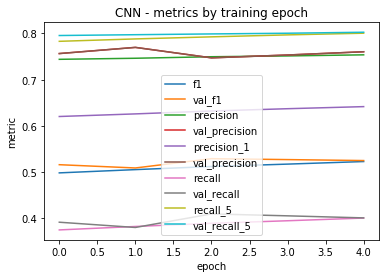

In [26]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", "precision_1", "val_precision",
                              "recall", "val_recall", "recall_5", "val_recall_5"], "CNN - metrics by training epoch")

In [29]:
# weighted binary crossentropy epochs 0-5
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=5,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 1599844 samples, validate on 400303 samples
Epoch 1/5
1599844/1599844 [==============================] - 9489s 6ms/sample - loss: 0.0155 - f1: 0.4174 - precision: 0.2468 - precision_1: 0.4923 - recall: 0.3436 - recall_5: 0.6722 - val_loss: 0.0095 - val_f1: 0.5131 - val_precision: 0.6210 - val_precision_1: 0.5805 - val_recall: 0.4373 - val_recall_5: 0.7591
Epoch 2/5
1599844/1599844 [==============================] - 9482s 6ms/sample - loss: 0.0100 - f1: 0.4972 - precision: 0.5984 - precision_1: 0.5696 - recall: 0.4256 - recall_5: 0.7445 - val_loss: 0.0090 - val_f1: 0.5347 - val_precision: 0.6315 - val_precision_1: 0.6031 - val_recall: 0.4638 - val_recall_5: 0.7759
Epoch 3/5
1599844/1599844 [==============================] - 9485s 6ms/sample - loss: 0.0095 - f1: 0.5173 - precision: 0.6099 - precision_1: 0.5899 - recall: 0.4494 - recall_5: 0.7620 - val_loss: 0.0088 - val_f1: 0.5460 - val_precision: 0.6371 - val_precision_1: 0.6134 - val_recall: 0.4777 - val_recall_5: 0.7847
Epoch

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1425024/1599844 [=========================>....] - ETA: 13:59 - loss: 0.0093 - f1: 0.5290 - precision: 0.6165 - precision_1: 0.6017 - recall: 0.4635 - recall_5: 0.7725

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 996096/1599844 [=================>............] - ETA: 48:21 - loss: 0.0090 - f1: 0.5382 - precision: 0.6206 - precision_1: 0.6109 - recall: 0.4753 - recall_5: 0.7812

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
# weighted binary crossentropy epochs 5-10
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=5,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 1599844 samples, validate on 400303 samples
Epoch 1/5
1599844/1599844 [==============================] - 9504s 6ms/sample - loss: 0.0089 - f1: 0.5441 - precision: 0.6237 - precision_1: 0.6173 - recall: 0.4827 - recall_5: 0.7866 - val_loss: 0.0085 - val_f1: 0.5609 - val_precision: 0.6450 - val_precision_1: 0.6285 - val_recall: 0.4961 - val_recall_5: 0.7971
Epoch 2/5
1599844/1599844 [==============================] - 9502s 6ms/sample - loss: 0.0088 - f1: 0.5500 - precision: 0.6265 - precision_1: 0.6234 - recall: 0.4904 - recall_5: 0.7919 - val_loss: 0.0084 - val_f1: 0.5665 - val_precision: 0.6361 - val_precision_1: 0.6323 - val_recall: 0.5105 - val_recall_5: 0.8000
Epoch 3/5
1599844/1599844 [==============================] - 9504s 6ms/sample - loss: 0.0086 - f1: 0.5545 - precision: 0.6284 - precision_1: 0.6283 - recall: 0.4962 - recall_5: 0.7967 - val_loss: 0.0084 - val_f1: 0.5665 - val_precision: 0.6449 - val_precision_1: 0.6344 - val_recall: 0.5050 - val_recall_5: 0.8012
Epoch

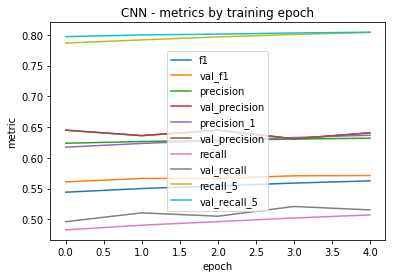

In [31]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", "precision_1", "val_precision",
                              "recall", "val_recall", "recall_5", "val_recall_5"], "CNN - metrics by training epoch")

In [32]:
# weighted binary crossentropy epochs 5-10
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=5,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 1599844 samples, validate on 400303 samples
Epoch 1/5
1599844/1599844 [==============================] - 9466s 6ms/sample - loss: 0.0083 - f1: 0.5665 - precision: 0.6338 - precision_1: 0.6407 - recall: 0.5124 - recall_5: 0.8078 - val_loss: 0.0083 - val_f1: 0.5721 - val_precision: 0.6332 - val_precision_1: 0.6380 - val_recall: 0.5216 - val_recall_5: 0.8036
Epoch 2/5
1599844/1599844 [==============================] - 9490s 6ms/sample - loss: 0.0082 - f1: 0.5698 - precision: 0.6352 - precision_1: 0.6445 - recall: 0.5169 - recall_5: 0.8112 - val_loss: 0.0083 - val_f1: 0.5735 - val_precision: 0.6402 - val_precision_1: 0.6397 - val_recall: 0.5194 - val_recall_5: 0.8047
Epoch 3/5
1599844/1599844 [==============================] - 9492s 6ms/sample - loss: 0.0082 - f1: 0.5726 - precision: 0.6362 - precision_1: 0.6476 - recall: 0.5207 - recall_5: 0.8138 - val_loss: 0.0083 - val_f1: 0.5765 - val_precision: 0.6123 - val_precision_1: 0.6399 - val_recall: 0.5444 - val_recall_5: 0.8055
Epoch

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='BERT_model.png')

TypeError: 'BertLayer' object is not iterable

In [29]:
# with binary cross_entropy, dropout 0.5 in the final layer and max sentence length 250
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=20,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 282710 samples, validate on 70524 samples
Epoch 1/20
282710/282710 [==============================] - 3444s 12ms/sample - loss: 0.0319 - f1: 0.2218 - precision: 0.0386 - precision_1: 0.3769 - recall: 0.1515 - recall_5: 0.4944 - val_loss: 0.0082 - val_f1: 0.3688 - val_precision: 0.7140 - val_precision_1: 0.5387 - val_recall: 0.2486 - val_recall_5: 0.6603
Epoch 2/20
282710/282710 [==============================] - 3440s 12ms/sample - loss: 0.0082 - f1: 0.3821 - precision: 0.6753 - precision_1: 0.5580 - recall: 0.2667 - recall_5: 0.6732 - val_loss: 0.0073 - val_f1: 0.4261 - val_precision: 0.7412 - val_precision_1: 0.6070 - val_recall: 0.2989 - val_recall_5: 0.7172
Epoch 3/20
282710/282710 [==============================] - 3440s 12ms/sample - loss: 0.0076 - f1: 0.4276 - precision: 0.6922 - precision_1: 0.6023 - recall: 0.3094 - recall_5: 0.7079 - val_loss: 0.0069 - val_f1: 0.4567 - val_precision: 0.7531 - val_precision_1: 0.6323 - val_recall: 0.3276 - val_recall_5: 0.7375
Epoch 4

KeyboardInterrupt: 

In [25]:
# with weighted binary cross_entropy, dropout 0.2 in the final layer and max sentence length 250
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=20,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 282710 samples, validate on 70524 samples
Epoch 1/20
282710/282710 [==============================] - 3448s 12ms/sample - loss: 0.0332 - f1: 0.3722 - precision: 0.0908 - precision_1: 0.4768 - recall: 0.3038 - recall_5: 0.5952 - val_loss: 0.0124 - val_f1: 0.4945 - val_precision: 0.5360 - val_precision_1: 0.6003 - val_recall: 0.4588 - val_recall_5: 0.7093
Epoch 2/20
282710/282710 [==============================] - 3441s 12ms/sample - loss: 0.0120 - f1: 0.4932 - precision: 0.5848 - precision_1: 0.6111 - recall: 0.4267 - recall_5: 0.7220 - val_loss: 0.0113 - val_f1: 0.5172 - val_precision: 0.6284 - val_precision_1: 0.6349 - val_recall: 0.4394 - val_recall_5: 0.7377
Epoch 3/20
282710/282710 [==============================] - 3438s 12ms/sample - loss: 0.0111 - f1: 0.5243 - precision: 0.5989 - precision_1: 0.6440 - recall: 0.4661 - recall_5: 0.7497 - val_loss: 0.0108 - val_f1: 0.5398 - val_precision: 0.6141 - val_precision_1: 0.6539 - val_recall: 0.4815 - val_recall_5: 0.7534
Epoch 4

KeyboardInterrupt: 

In [23]:
# with binary cross_entropy, dropout 0.2 in the final layer and max sentence length 300
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_test_k, y_test_k),
    epochs=10,
    batch_size=128#,
    #callbacks=[tensorboard]
)

Train on 282710 samples, validate on 70524 samples
Epoch 1/10
282710/282710 [==============================] - 4228s 15ms/sample - loss: 0.0280 - f1: 0.2808 - precision: 0.0601 - precision_1: 0.4434 - recall: 0.1947 - recall_5: 0.5577 - val_loss: 0.0076 - val_f1: 0.4382 - val_precision: 0.6940 - val_precision_1: 0.5935 - val_recall: 0.3202 - val_recall_5: 0.6970
Epoch 2/10
282710/282710 [==============================] - 4224s 15ms/sample - loss: 0.0074 - f1: 0.4335 - precision: 0.7050 - precision_1: 0.6044 - recall: 0.3132 - recall_5: 0.7135 - val_loss: 0.0070 - val_f1: 0.4604 - val_precision: 0.7365 - val_precision_1: 0.6331 - val_recall: 0.3348 - val_recall_5: 0.7359
Epoch 3/10
282710/282710 [==============================] - 4224s 15ms/sample - loss: 0.0069 - f1: 0.4740 - precision: 0.7183 - precision_1: 0.6407 - recall: 0.3537 - recall_5: 0.7429 - val_loss: 0.0067 - val_f1: 0.4959 - val_precision: 0.7306 - val_precision_1: 0.6543 - val_recall: 0.3752 - val_recall_5: 0.7518
Epoch 4

## Model evaluation

In [28]:
score = model.evaluate(X_test_k, y_test_k, verbose=1)
score

70524/70524 [==============================] - 855s 12ms/sample - loss: 0.0064 - f1: 0.5527 - precision: 0.6992 - precision_1: 0.6845 - recall: 0.4551 - recall_5: 0.7754


[0.0063985379094089025,
 0.5527458,
 0.6991963,
 0.68453294,
 0.4551323,
 0.77540433]

In [25]:
def plot_metric(hist, metrics, title):
  for metric in metrics:
    metric_to_plot = hist[metric]
    plt.plot(metric_to_plot, label=metric)
  plt.title(title)
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("metric")

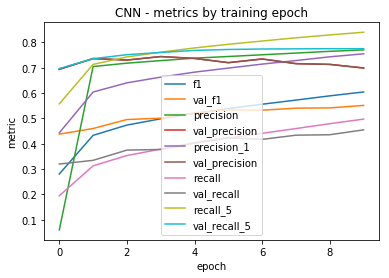

In [26]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", "precision_1", "val_precision",
                              "recall", "val_recall", "recall_5", "val_recall_5"], "CNN - metrics by training epoch")

In [37]:
# tf.keras.models.save_model(model, path + "BERT_keras_model.h5", include_optimizer=True)

In [33]:
y_pred = model.predict(X_train_k, batch_size=128)

In [34]:
# saves BERT predictions as pickle
import pickle
with open('BERT_y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

In [35]:
y_pred

array([[6.3180923e-06, 2.0861626e-07, 2.7120113e-06, ..., 1.2107790e-03,
        1.8775463e-06, 2.4020672e-05],
       [7.8082085e-06, 6.6965818e-05, 5.3644180e-07, ..., 1.1198401e-02,
        2.6285648e-04, 9.7453594e-06],
       [7.4505806e-07, 8.9406967e-08, 6.6161156e-06, ..., 2.1677613e-03,
        7.8886807e-02, 1.6263127e-04],
       ...,
       [1.6897917e-05, 1.6391277e-06, 6.5565109e-07, ..., 1.1271238e-04,
        8.5085630e-05, 6.2891841e-04],
       [1.4901161e-07, 8.9406967e-08, 2.6822090e-07, ..., 4.3511391e-06,
        7.8976154e-06, 2.8097630e-04],
       [8.4395081e-02, 1.3625622e-04, 3.7759542e-05, ..., 9.2387199e-07,
        2.3841858e-07, 1.4099479e-04]], dtype=float32)